In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

--2022-04-04 14:42:18--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2022-04-04 14:42:18--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?p5WDU8R7cwX17Qb5Yr3gMRjg12oDYLp9PAUWWAZ7f-YO8XccTjz7LfbcpJpFdSR387sLizKEzC02EsSuURxtLs8n3rfD-

In [3]:
!ls

 AirI.csv
 cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
'DATA_310_Classification_Problems (2).ipynb'
 DATA_310_Some_Ideas_for_Project_3.ipynb
 Midterm.ipynb
 Project_1.ipynb
 Project_2.ipynb
 Project_3.ipynb
 qsar_fish_toxicity.csv
 safe_driver_prediction.csv


In [4]:
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

dpkg: error: requested operation requires superuser privilege
ls: cannot access '/var/cuda-repo-9-0-local': No such file or directory
E: gnupg, gnupg2 and gnupg1 do not seem to be installed, but one of them is required for this operation
Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
[sudo] password for jovyan: 


In [5]:
!pip install thundersvm

In [6]:
!pip install faiss-gpu

     |████████████████████████████████| 85.5 MB 112 kB/s 


In [7]:
import numpy as np
import faiss
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from thundersvm import SVC
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split as tts
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import plot_roc_curve

In [8]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [9]:
data = pd.read_csv('drive/MyDrive/Data Sets/safe_driver_prediction.csv')

In [ ]:
data.dropna()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0


In [10]:
y = data.dropna()['target'].values

In [11]:
x = data.loc[:,'ps_ind_01':'ps_calc_20_bin'].values

In [ ]:
np.where(np.isnan(x))

(array([], dtype=int64), array([], dtype=int64))

In [12]:
ind1 = (y==1)
ind0 = (y==0)

In [14]:
np.random.seed(123)
ind0 = np.random.choice(np.array(np.where(y==0)).ravel(),30000, replace=False)
x0 = x[ind0,:]
y0 = y[ind0]
x1 = x[(y==1),:]
y1 = y[(y==1)]

In [ ]:
# alternatively we can use the pandas sample
data.sample(n=100000,random_state=123, replace=False)

In [15]:
xm = np.concatenate([x0,x1],axis=0)
ym = np.concatenate([y0,y1],axis=0)

In [16]:
ym.shape

(51694,)

In [17]:
scale = StandardScaler()
xs = scale.fit_transform(xm)

In [18]:
model = GaussianNB(var_smoothing=1e-9)

In [19]:
model.fit(xs,ym)

GaussianNB()

In [20]:
print(classification_report(ym,model.predict(xs)))

              precision    recall  f1-score   support

           0       0.63      0.81      0.70     30000
           1       0.55      0.33      0.42     21694

    accuracy                           0.61     51694
   macro avg       0.59      0.57      0.56     51694
weighted avg       0.60      0.61      0.58     51694



In [30]:
model = FaissKNeighbors(k=7)

In [31]:
model.fit(xs,ym)

In [32]:
print(classification_report(ym,model.predict(xs)))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75     30000
           1       0.67      0.51      0.58     21694

    accuracy                           0.69     51694
   macro avg       0.68      0.66      0.67     51694
weighted avg       0.69      0.69      0.68     51694



In [33]:
# the FaissKNeighbors may not have predict_proba_
model.predict_proba(xs)

AttributeError: ignored

In [25]:
model = SVC(kernel='rbf',C=1, gamma=0.1,probability=True)
model.fit(xs,ym)
print(classification_report(ym,model.predict(xs)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     30000
           1       1.00      0.99      1.00     21694

    accuracy                           1.00     51694
   macro avg       1.00      1.00      1.00     51694
weighted avg       1.00      1.00      1.00     51694



In [26]:
y_pred_proba = model.predict_proba(xs)[:,1]

In [27]:
y_pred_proba # just a long array but not a 2-column matrix that has the complement probability values such as an sklearn function

array([0.1864252 , 0.18650037, 0.18649268, ..., 0.83175594, 0.74724424,
       0.74170357], dtype=float32)

AttributeError: ignored

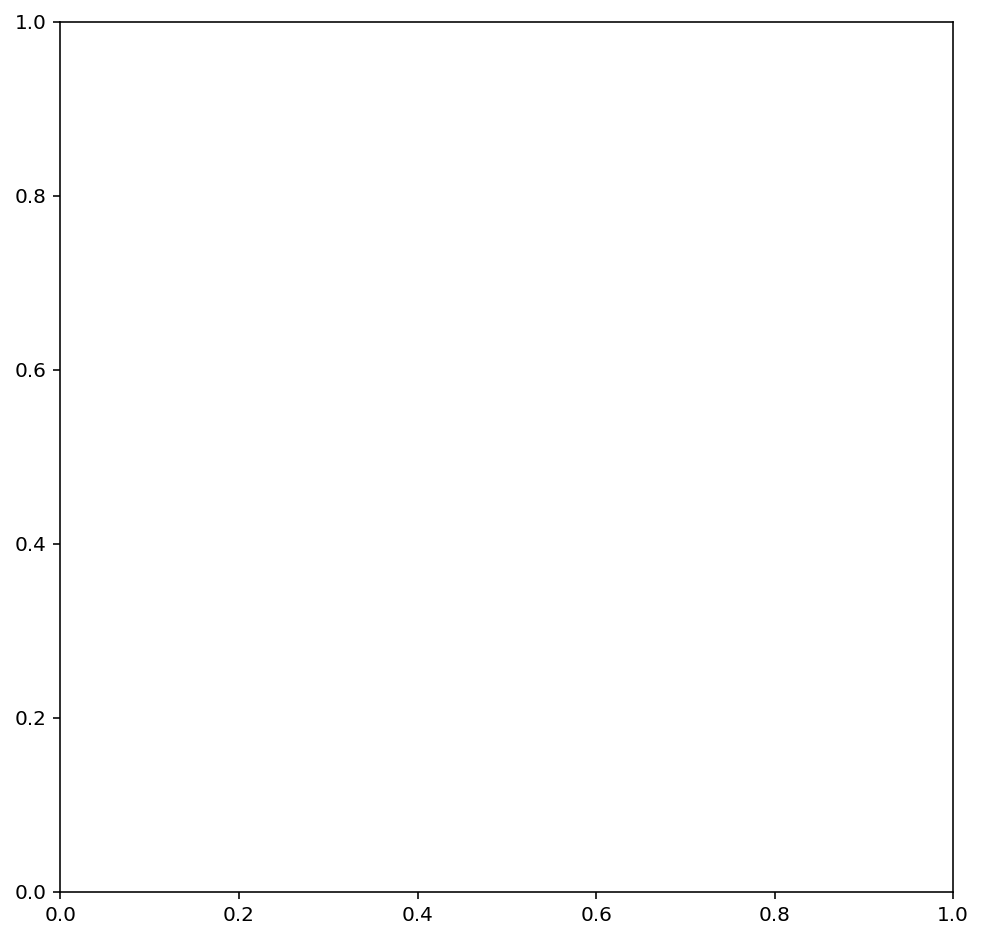

In [28]:
# here we show that this is a problem when you try to use directly the sklearn function plot_roc_curve
fig, ax = plt.subplots(figsize=(8,8))
viz = plot_roc_curve(model, xs, ym,name='ROC fold {}'.format(1),alpha=0.5, lw=1, ax=ax)

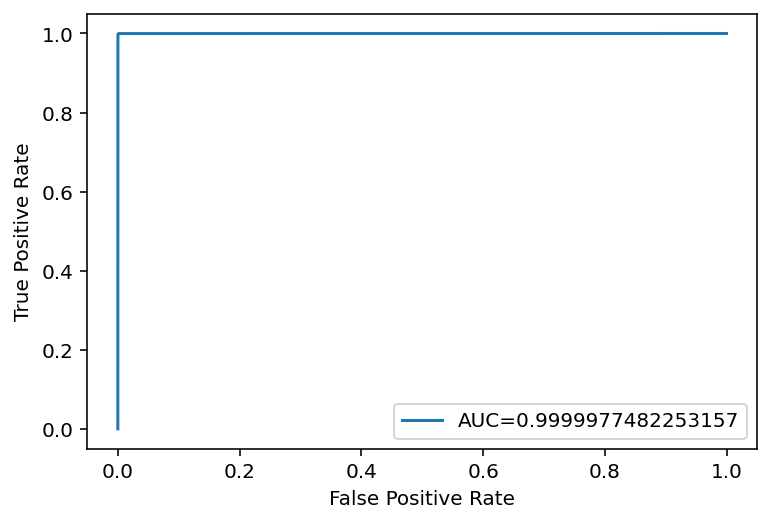

In [29]:
# here is a solution to this problem
fpr, tpr, _ = roc_curve(ym,  y_pred_proba)
auc = roc_auc_score(ym, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.svm import SVC as SVCsk

In [ ]:
model2=SVCsk(kernel='rbf',gamma=0.1,C=1,probability=True)

In [ ]:
model2.fit(xs,ym)

SVC(C=1, gamma=0.01, probability=True)

In [ ]:
y_pred_proba = model2.predict_proba(xs)[::,1]

In [ ]:
print(classification_report(ym,model2.predict(xs)))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65     22000
           1       0.65      0.60      0.62     21694

    accuracy                           0.64     43694
   macro avg       0.64      0.64      0.64     43694
weighted avg       0.64      0.64      0.64     43694



In [ ]:
model = KNeighborsClassifier(n_neighbors=5,weights='distance')
model.fit(xs,ym)
print(classification_report(ym,model.predict(xs)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100000
           1       1.00      1.00      1.00     21694

    accuracy                           1.00    121694
   macro avg       1.00      1.00      1.00    121694
weighted avg       1.00      1.00      1.00    121694



In [ ]:
model = RandomForestClassifier(n_estimators=100,max_depth=5)
model.fit(xs,ym)
print(classification_report(ym,model.predict(xs)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90    100000
           1       1.00      0.00      0.00     21694

    accuracy                           0.82    121694
   macro avg       0.91      0.50      0.45    121694
weighted avg       0.85      0.82      0.74    121694

